# Compute Techiness without Outliers
- Fixed Entropy Version (divided by 100)
- Outliers: ln_entropy 계산 간 발생. (too small volume of counts in some cluster)

### 1) Load Data

In [1]:
import pandas as pd
import pickle
import numpy as np

# Load Data (preChatGPT)
with open(file = 'ques_df_pre.pickle', mode = 'rb') as file:
    ques_df = pickle.load(file)
with open(file = 'ans_df_pre.pickle', mode = 'rb') as file:
    ans_df = pickle.load(file)

In [2]:
ques_df['creation_date'] = pd.to_datetime(ques_df['creation_date'])
ques_df['year_month_day'] = ques_df['creation_date'].dt.to_period('D') # daily
daily_q = ques_df.groupby(['year_month_day', 'community']).size().reset_index(name = 'count_q')

ans_df['creation_date'] = pd.to_datetime(ans_df['creation_date'])
ans_df['year_month_day'] = ans_df['creation_date'].dt.to_period('D') # daily
daily_a = ans_df.groupby(['year_month_day', 'community']).size().reset_index(name = 'count_a')

df_merge = pd.merge(daily_q, daily_a, on = ['year_month_day', 'community'])
df_merge['year_month_day'] = df_merge['year_month_day'].astype(str)

In [3]:
df_merge

,year_month_day,community,count_q,count_a
0,2021-09-01,0,1213,1029
1,2021-09-01,1,401,225
2,2021-09-01,3,394,250
3,2021-09-01,4,368,305
4,2021-09-01,5,378,258
...,...,...,...,...
10746,2023-08-31,11,18,12
10747,2023-08-31,13,29,18
10748,2023-08-31,14,8,1
10749,2023-08-31,15,5,4


In [4]:
df_merge[df_merge['year_month_day'] == '2021-09-01'] # there are some missing communities as they are zero.

,year_month_day,community,count_q,count_a
0,2021-09-01,0,1213,1029
1,2021-09-01,1,401,225
2,2021-09-01,3,394,250
3,2021-09-01,4,368,305
4,2021-09-01,5,378,258
5,2021-09-01,6,470,405
6,2021-09-01,7,231,126
7,2021-09-01,8,103,79
8,2021-09-01,9,35,16
9,2021-09-01,10,5,2


In [5]:
# 1) Calculate Code Ratio (code_body / full_body)
ques_df['techiness'] = ques_df['code_body'].apply(len) / ques_df['full_body'].apply(len)
# 2) Community Aggregation
agg_q_monthly = ques_df.groupby('community')['techiness'].mean().reset_index()
# Copy the data vertically 730 times (copy for each day)
agg_q_monthly = pd.concat([agg_q_monthly] * 730, ignore_index=True) # this should be 13140
agg_q_monthly

,community,techiness
0,0,0.525040
1,1,0.412791
2,2,0.127386
3,3,0.490224
4,4,0.439161
...,...,...
13135,13,0.421145
13136,14,0.403302
13137,15,0.307775
13138,16,0.337905


In [6]:
# Load entropy data
with open(file = '/data1/StackOverflow/_Robustness/TagCluster/ent_Score2.pickle', mode = 'rb') as file:
    ent_Score = pickle.load(file)
# Merge Data
agg_q_monthly['entropy'] = ent_Score
agg_q_monthly

,community,techiness,entropy
0,0,0.525040,7.298398
1,1,0.412791,7.399966
2,2,0.127386,0.000000
3,3,0.490224,7.231138
4,4,0.439161,7.709924
...,...,...,...
13135,13,0.421145,5.528088
13136,14,0.403302,3.344698
13137,15,0.307775,2.947703
13138,16,0.337905,0.000000


### 2) Load Pre Computed DiD Tables

In [7]:
# Load pre-computed did tables
post = pd.read_csv("/data1/StackOverflow/diff_in_diff/numPosts_did.csv")
entropy = pd.read_csv('/data1/StackOverflow/_Robustness/entropy_did.csv')
lsm = pd.read_csv('/data1/StackOverflow/diff_in_diff/lsm_did2_modified.csv')

post = post.drop(['count_q', 'count_a', 'ln_q', 'ln_a'], axis = 1)
# Copy code 19 times (19 clusters)
extend_post = pd.concat([post.loc[post.index.repeat(18)].reset_index(drop=True)])
df_final = pd.concat([extend_post, agg_q_monthly], axis=1)
df_final

,year_month_day,T_d,P_t,month,community,techiness,entropy
0,2021-09-01,0,0,9,0,0.525040,7.298398
1,2021-09-01,0,0,9,1,0.412791,7.399966
2,2021-09-01,0,0,9,2,0.127386,0.000000
3,2021-09-01,0,0,9,3,0.490224,7.231138
4,2021-09-01,0,0,9,4,0.439161,7.709924
...,...,...,...,...,...,...,...
13135,2023-08-31,1,1,8,13,0.421145,5.528088
13136,2023-08-31,1,1,8,14,0.403302,3.344698
13137,2023-08-31,1,1,8,15,0.307775,2.947703
13138,2023-08-31,1,1,8,16,0.337905,0.000000


In [8]:
# Left merge and convert na values to 0.
df_final = pd.merge(df_final, df_merge, on = ['year_month_day', 'community'], how = 'left')
df_final['count_q'] = df_final['count_q'].fillna(0)
df_final['count_a'] = df_final['count_a'].fillna(0)
df_final['ln_q'] = np.log(df_final['count_q'])
df_final['ln_a'] = np.log(df_final['count_a'])
df_final

/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,ln_a
0,2021-09-01,0,0,9,0,0.525040,7.298398,1213.0,1029.0,7.100852,6.936343
1,2021-09-01,0,0,9,1,0.412791,7.399966,401.0,225.0,5.993961,5.416100
2,2021-09-01,0,0,9,2,0.127386,0.000000,0.0,0.0,-inf,-inf
3,2021-09-01,0,0,9,3,0.490224,7.231138,394.0,250.0,5.976351,5.521461
4,2021-09-01,0,0,9,4,0.439161,7.709924,368.0,305.0,5.908083,5.720312
...,...,...,...,...,...,...,...,...,...,...,...
13135,2023-08-31,1,1,8,13,0.421145,5.528088,29.0,18.0,3.367296,2.890372
13136,2023-08-31,1,1,8,14,0.403302,3.344698,8.0,1.0,2.079442,0.000000
13137,2023-08-31,1,1,8,15,0.307775,2.947703,5.0,4.0,1.609438,1.386294
13138,2023-08-31,1,1,8,16,0.337905,0.000000,0.0,0.0,-inf,-inf


### Visualization

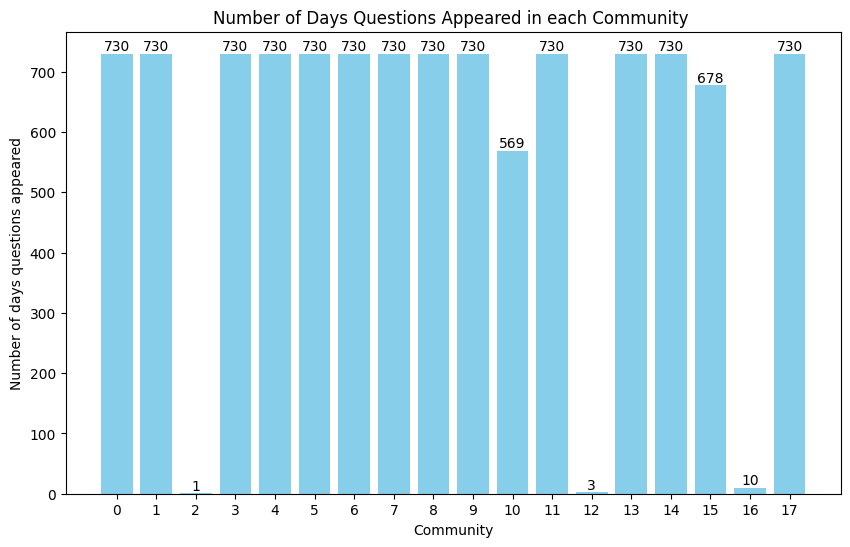

In [41]:
# 총 730개 중 몇몇 클러스터에서 등장한 횟수가 10번 이하인 것은 제외.
vis_count = df_final.groupby('community')['count_q'].apply(lambda x: (x != 0).sum()).reset_index()

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
bars = plt.bar(vis_count['community'].astype(str), vis_count['count_q'], color='skyblue')

# Adding titles and labels
plt.title('Number of Days Questions Appeared in each Community ')
plt.xlabel('Community')
plt.ylabel('Number of days questions appeared')

# Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval),ha = 'center', va='bottom')  # va: vertical alignment

# Display the plot
plt.show()

In [14]:
df_final.groupby('community')['count_q'].apply(lambda x: (x == 0).sum()).reset_index()

,community,count_q
0,0,0
1,1,0
2,2,729
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


In [43]:
df_final.groupby('community')['entropy'].apply(lambda x: (x == 0).sum()).reset_index()

,community,entropy
0,0,0
1,1,0
2,2,712
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


### Outlier control
- Analyze without the outliers clusters. (13,140 -> after erasing clusters (10,950)-> erase -inf (10,712))

In [44]:
# Erase tags with the clusters (2, 12, 16)
df_final

,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,ln_a
0,2021-09-01,0,0,9,0,0.525040,7.298398,1213.0,1029.0,7.100852,6.936343
1,2021-09-01,0,0,9,1,0.412791,7.399966,401.0,225.0,5.993961,5.416100
2,2021-09-01,0,0,9,2,0.127386,0.000000,0.0,0.0,-inf,-inf
3,2021-09-01,0,0,9,3,0.490224,7.231138,394.0,250.0,5.976351,5.521461
4,2021-09-01,0,0,9,4,0.439161,7.709924,368.0,305.0,5.908083,5.720312
...,...,...,...,...,...,...,...,...,...,...,...
13135,2023-08-31,1,1,8,13,0.421145,5.528088,29.0,18.0,3.367296,2.890372
13136,2023-08-31,1,1,8,14,0.403302,3.344698,8.0,1.0,2.079442,0.000000
13137,2023-08-31,1,1,8,15,0.307775,2.947703,5.0,4.0,1.609438,1.386294
13138,2023-08-31,1,1,8,16,0.337905,0.000000,0.0,0.0,-inf,-inf


In [46]:
df_final = df_final[(df_final['community'] != 2)&(df_final['community'] != 12)&(df_final['community'] != 16)]
df_final

,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,ln_a
0,2021-09-01,0,0,9,0,0.525040,7.298398,1213.0,1029.0,7.100852,6.936343
1,2021-09-01,0,0,9,1,0.412791,7.399966,401.0,225.0,5.993961,5.416100
3,2021-09-01,0,0,9,3,0.490224,7.231138,394.0,250.0,5.976351,5.521461
4,2021-09-01,0,0,9,4,0.439161,7.709924,368.0,305.0,5.908083,5.720312
5,2021-09-01,0,0,9,5,0.461350,7.043218,378.0,258.0,5.934894,5.552960
...,...,...,...,...,...,...,...,...,...,...,...
13133,2023-08-31,1,1,8,11,0.476285,4.175869,18.0,12.0,2.890372,2.484907
13135,2023-08-31,1,1,8,13,0.421145,5.528088,29.0,18.0,3.367296,2.890372
13136,2023-08-31,1,1,8,14,0.403302,3.344698,8.0,1.0,2.079442,0.000000
13137,2023-08-31,1,1,8,15,0.307775,2.947703,5.0,4.0,1.609438,1.386294


In [63]:
# erase -inf values
import numpy as np
df_final['ln_entropy'] = np.log(df_final['entropy'])
df_final.replace(-np.inf, np.nan, inplace=True)
df_final = df_final.dropna()

/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_3591770/2540224774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['ln_entropy'] = np.log(df_final['entropy'])
/tmp/ipykernel_3591770/2540224774.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.replace(-np.inf, np.nan, inplace=True)


In [65]:
df_final

,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,ln_a,ln_entropy
0,2021-09-01,0,0,9,0,0.525040,7.298398,1213.0,1029.0,7.100852,6.936343,1.987655
1,2021-09-01,0,0,9,1,0.412791,7.399966,401.0,225.0,5.993961,5.416100,2.001475
3,2021-09-01,0,0,9,3,0.490224,7.231138,394.0,250.0,5.976351,5.521461,1.978396
4,2021-09-01,0,0,9,4,0.439161,7.709924,368.0,305.0,5.908083,5.720312,2.042508
5,2021-09-01,0,0,9,5,0.461350,7.043218,378.0,258.0,5.934894,5.552960,1.952065
...,...,...,...,...,...,...,...,...,...,...,...,...
13133,2023-08-31,1,1,8,11,0.476285,4.175869,18.0,12.0,2.890372,2.484907,1.429322
13135,2023-08-31,1,1,8,13,0.421145,5.528088,29.0,18.0,3.367296,2.890372,1.709842
13136,2023-08-31,1,1,8,14,0.403302,3.344698,8.0,1.0,2.079442,0.000000,1.207377
13137,2023-08-31,1,1,8,15,0.307775,2.947703,5.0,4.0,1.609438,1.386294,1.081026


In [66]:
# Final Setup
df_final['year_month_day'] = pd.to_datetime(df_final['year_month_day'])
df_final['year_month'] = df_final['year_month_day'].dt.to_period('M') # monthly
df_final['year_month'] = df_final['year_month'].astype(str)
df_final['year_month_day'] = df_final['year_month_day'].astype(str)

/tmp/ipykernel_3591770/3507927988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['year_month_day'] = pd.to_datetime(df_final['year_month_day'])
/tmp/ipykernel_3591770/3507927988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['year_month'] = df_final['year_month_day'].dt.to_period('M') # monthly
/tmp/ipykernel_3591770/3507927988.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [67]:
df_final

,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,ln_a,ln_entropy,year_month
0,2021-09-01,0,0,9,0,0.525040,7.298398,1213.0,1029.0,7.100852,6.936343,1.987655,2021-09
1,2021-09-01,0,0,9,1,0.412791,7.399966,401.0,225.0,5.993961,5.416100,2.001475,2021-09
3,2021-09-01,0,0,9,3,0.490224,7.231138,394.0,250.0,5.976351,5.521461,1.978396,2021-09
4,2021-09-01,0,0,9,4,0.439161,7.709924,368.0,305.0,5.908083,5.720312,2.042508,2021-09
5,2021-09-01,0,0,9,5,0.461350,7.043218,378.0,258.0,5.934894,5.552960,1.952065,2021-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13133,2023-08-31,1,1,8,11,0.476285,4.175869,18.0,12.0,2.890372,2.484907,1.429322,2023-08
13135,2023-08-31,1,1,8,13,0.421145,5.528088,29.0,18.0,3.367296,2.890372,1.709842,2023-08
13136,2023-08-31,1,1,8,14,0.403302,3.344698,8.0,1.0,2.079442,0.000000,1.207377,2023-08
13137,2023-08-31,1,1,8,15,0.307775,2.947703,5.0,4.0,1.609438,1.386294,1.081026,2023-08


In [68]:
df_final.describe()

,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,ln_a,ln_entropy
count,10712.000000,10712.000000,10712.000000,10712.000000,10712.000000,10712.000000,10712.000000,10712.000000,10712.000000,10712.000000,10712.000000
mean,0.499720,0.752987,6.526606,8.132468,0.427730,5.789200,253.317774,236.456591,4.483028,4.372681,1.694570
std,0.500023,0.431294,3.448711,5.006718,0.070404,1.771778,305.877974,302.899739,1.763558,1.783374,0.380504
min,0.000000,0.000000,1.000000,0.000000,0.304784,0.918296,1.000000,1.000000,0.000000,0.000000,-0.085236
25%,0.000000,1.000000,4.000000,4.000000,0.373225,4.252931,21.000000,19.000000,3.044522,2.944439,1.447608
50%,0.000000,1.000000,7.000000,8.000000,0.421145,6.600045,161.000000,133.000000,5.081404,4.890349,1.887076
75%,1.000000,1.000000,10.000000,13.000000,0.483382,7.333593,363.000000,331.000000,5.894403,5.802118,1.992466
max,1.000000,1.000000,12.000000,17.000000,0.541652,8.300774,1437.000000,1364.000000,7.270313,7.218177,2.116349


In [69]:
# Save Data
df_final.to_csv('df_final_pre3.csv', index=False)